In [96]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [97]:
import numpy as np
import pandas as pd

In [98]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [99]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [100]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [101]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [102]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [103]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [104]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [129]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-23").\
    filter(Measurement.date <= "2017-08-23").all()

In [130]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df = pd.DataFrame(precipitation_data , columns=['Date','Percipitation'])
df = df.set_index('Date')
df.head(12)


,Percipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
2016-08-29,0.00
2016-08-30,0.00
2016-08-31,0.13


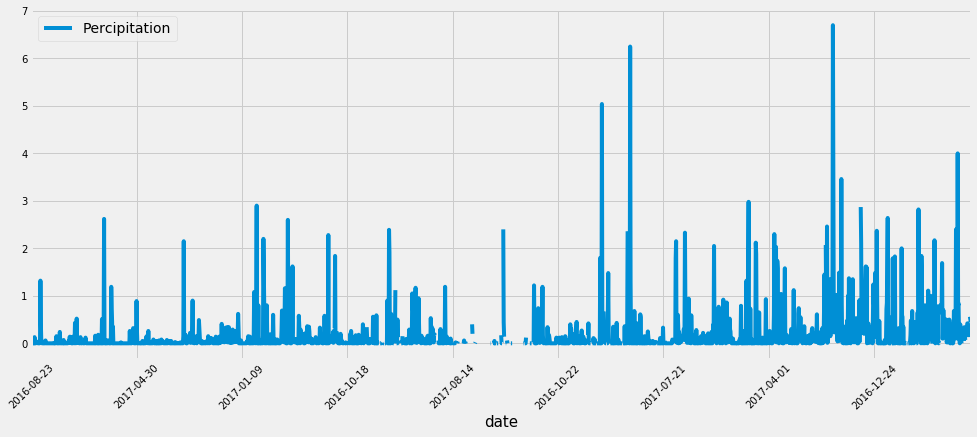

In [131]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(15, 6),                                             
               sort_columns=True, 
               rot=45, 
               use_index=True,  
               legend=True,
               fontsize=10,
               grid=True )

plt.xlabel('date', fontsize=15)
plt.show()

In [132]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe

<bound method NDFrame.describe of             Percipitation
Date                     
2016-08-23           0.00
2016-08-24           0.08
2016-08-25           0.08
2016-08-26           0.00
2016-08-27           0.00
...                   ...
2017-08-19           0.09
2017-08-20            NaN
2017-08-21           0.56
2017-08-22           0.50
2017-08-23           0.45

[2230 rows x 1 columns]>

In [133]:
# Design a query to show how many stations are available in this dataset?
station_total = session.query(Station.id).count()

print(station_total)

9


In [134]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [135]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == "USC00519281").all()
temps

[(54.0, 85.0, 71.66378066378067)]

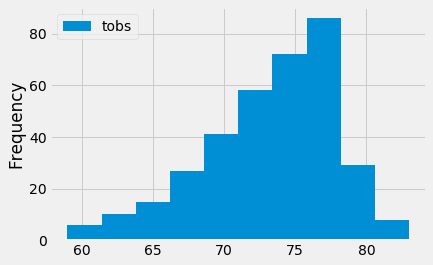

In [136]:
# Choose the station with the highest number of temperature observations.

station_high_temp = session.query(Measurement.tobs).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= '2016-08-23')

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

hdf = pd.DataFrame(station_high_temp, columns=['tobs'])
hdf.plot.hist();
plt.savefig("images/station_weather.png")
plt.show()

In [137]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [138]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
results = calc_temps('2012-02-28', '2012-03-05')
print(results)

[(62.0, 69.57142857142857, 74.0)]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


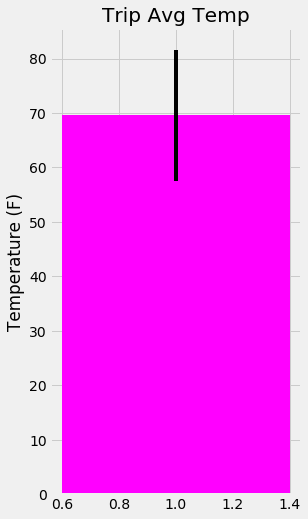

In [139]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize=plt.figaspect(2.))
peak = results[0][2] - results[0][0]
bar = ax.bar(1, results[0][1], yerr = peak, color = "fuchsia")
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F)")
fig.show()


In [158]:

# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall = session.query(Measurement.station, Station.name,Station.latitude, Station.longitude, Station.elevation, 
                         func.count(Measurement.prcp)).\
group_by(Station.name,Station.latitude, Station.longitude, Station.elevation).order_by(func.count(Measurement.prcp).desc()).all()
print (rainfall)


[('USC00519397', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 18103), ('USC00519397', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 18103), ('USC00519397', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 18103), ('USC00519397', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 18103), ('USC00519397', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 18103), ('USC00519397', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 18103), ('USC00519397', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 18103), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 18103), ('USC00519397', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 18103)]
